<a href="https://colab.research.google.com/github/makezazainw/newresultsproject/blob/main/Lab_Augmentation_VGG19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **ติดตั้ง Kaggle เเละ เรียกใช้ไฟล์ json เพื่อติดต่อใช้ dataset ใน kaggle**

In [1]:
# Install Kaggle API
!pip install -q kaggle
!pip install -q kaggle-cli

     |████████████████████████████████| 81kB 6.0MB/s 
     |████████████████████████████████| 5.3MB 7.2MB/s 
     |████████████████████████████████| 133kB 40.0MB/s 
     |████████████████████████████████| 51kB 8.8MB/s 
     |████████████████████████████████| 112kB 52.5MB/s 


In [2]:
# only for google colab
import os
os.environ['KAGGLE_USERNAME'] = "thammatattantipitham" 
os.environ['KAGGLE_KEY'] = "3cf826ab97707228fb1602519992740b"

In [3]:
!kaggle datasets download -d thammatattantipitham/labaugthaiherb --unzip

 93% 55.0M/59.0M [00:00<00:00, 43.3MB/s]
100% 59.0M/59.0M [00:00<00:00, 71.5MB/s]


In [4]:
#สร้างไฟล์ folder ขึ้นมาเเละเพิ่มข้อมูลเข้าไปใน folder
!mkdir labaugthaiherb
!mv  "train" "val" labaugthaiherb

### **เริ่มต้นการ import library ต่างๆเเละการเรียกใช้ไฟล์**


In [5]:
import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import keras

from skimage.transform import resize
from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.applications.vgg19 import VGG19
from tensorflow.python.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.optimizers import Adam
from keras.applications import InceptionV3
sys.version

'3.6.9 (default, Oct  8 2020, 12:12:24) \n[GCC 8.4.0]'

In [6]:
from tensorflow.compat.v1.keras.backend import set_session

config = tf.compat.v1.ConfigProto()

config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU

config.log_device_placement = True  # to log device placement (on which device the operation ran)

sess = tf.compat.v1.Session(config=config)

set_session(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



In [7]:
DATASET_PATH  = 'labaugthaiherb/'
IMAGE_SIZE    = (224, 224)
NUM_CLASSES   = 10
BATCH_SIZE    = 32  # try reducing batch size or freeze more layers if your GPU runs out of memory
epochs    = 50

In [8]:
#ทำ aug มาเเล้ว
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [9]:
#set training data
train_generator = train_datagen.flow_from_directory(DATASET_PATH+ r"train/",
                                                    target_size = IMAGE_SIZE,
                                                    batch_size = BATCH_SIZE,
                                                    class_mode='categorical',
                                                    shuffle = True,
                                                    subset='training')

Found 17186 images belonging to 10 classes.


In [10]:
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
valid_generator = valid_datagen.flow_from_directory(DATASET_PATH+ r"val/",                                      
                                                    target_size = IMAGE_SIZE,
                                                    batch_size = 1,
                                                    class_mode='categorical',
                                                    shuffle = True
                                                    )

Found 4303 images belonging to 10 classes.


### **Model VGG19**

In [11]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "training_VGG19/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    period=10)

#Create the model
def create_model_from_VGG19():
    """
      use VGG19
    """
    model = VGG19(weights = "imagenet", include_top=False, input_tensor=None, input_shape = (224, 224, 3))
    
    #5 layers เเรก จะไม่ถูกฝึกเนื่องจากใช้วิธีการ freeze ไว้เเล้ว
    for layer in model.layers[:1]:
      layer.trainable = False
      
    #ทำการเพิ่ม layers ที่กำหนดขึ้นมาเอง เป็นการปรับเเต่งเพื่อเพิ่มประสิทธิภาพ 
    x = model.output
    x = Flatten()(x)
    x = Dense(1024, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation="relu")(x)
    predictions = Dense(NUM_CLASSES, activation="softmax")(x)
    
    #สร้าง model ชั้นสุดท้ายเพื่อจะนำมา compile
    model_VGG19 = Model(inputs = model.input, outputs = predictions)
    
    model_VGG19.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])

    return model_VGG19

    # Save the weights using the `checkpoint_path` format
    model_VGG19.save_weights(checkpoint_path.format(epoch=0))

In [12]:
model_VGG19 = create_model_from_VGG19()
model_VGG19.summary()

80142336/80134624 [==============================] - 0s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_______________________________________________________

In [13]:
start = time.time()

history = model_VGG19.fit_generator(
    generator=train_generator, 
    steps_per_epoch=train_generator.samples//BATCH_SIZE,   # -> 106 # images 3392 = steps * batch_size = 106 * 32 
    epochs=epochs, 
    validation_steps=valid_generator.samples//BATCH_SIZE, # -> 26 # images 832 = steps * batch_size = 26 * 32
    validation_data=valid_generator,
    callbacks = [cp_callback],
    verbose = 1
)

end = time.time()
duration = end - start
print ('\n model_VGG19 took %0.2f seconds (%0.1f minutes) to train for %d epochs'%(duration, duration/60, epochs) )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
537/537 [==============================] - 134s 249ms/step - loss: 2.3172 - accuracy: 0.0960 - val_loss: 2.3025 - val_accuracy: 0.1269
Epoch 2/50
537/537 [==============================] - 133s 248ms/step - loss: 2.3027 - accuracy: 0.1003 - val_loss: 2.3019 - val_accuracy: 0.1119
Epoch 3/50
537/537 [==============================] - 133s 248ms/step - loss: 2.3027 - accuracy: 0.0988 - val_loss: 2.3029 - val_accuracy: 0.0896
Epoch 4/50
537/537 [==============================] - 133s 248ms/step - loss: 2.3027 - accuracy: 0.1014 - val_loss: 2.3022 - val_accuracy: 0.1119
Epoch 5/50
537/537 [==============================] - 133s 248ms/step - loss: 2.3027 - accuracy: 0.0985 - val_loss: 2.3016 - val_accuracy: 0.1269
Epoch 6/50
537/537 [==============================] - 133s 248ms/step - loss: 2.3027 - accuracy: 0.1013 - val_loss: 2.3033 - val_accuracy: 0.1119
Epoch 7/50
537/537 [============================

###**ขั้นตอนการ Save file Model เเละ Json**

In [ ]:
#เปลี่ยนชื่อไฟล์ทุกครั้งเวลา SAVE
model_VGG19.save('/content/drive/My Drive/Final Project/Dataset-Lab/Original/saved_model/model-vgg19(auglastest).h5') #ดูจำนวนรอบที่เทรนด้วยว่าทั้งหมดกี่รอบจริงๆเเล้ว
model_VGG19.save_weights('/content/drive/My Drive/Final Project/Dataset-Lab/Original/saved_model/weightaugmodel-vgg19.h5')

In [ ]:
#Import dependencies
!mkdir jsonfile
import json
from keras.models import model_from_json, load_model
with open('jsonfile/model_VGG19(aug).json', 'w') as f:
    f.write(model_VGG19.to_json())
print("Saved model success")

###**เเสดงกราฟข้อมูลค่าความเเม่นยำเเละค่าความสูญเสีย Training เเละ Validation**

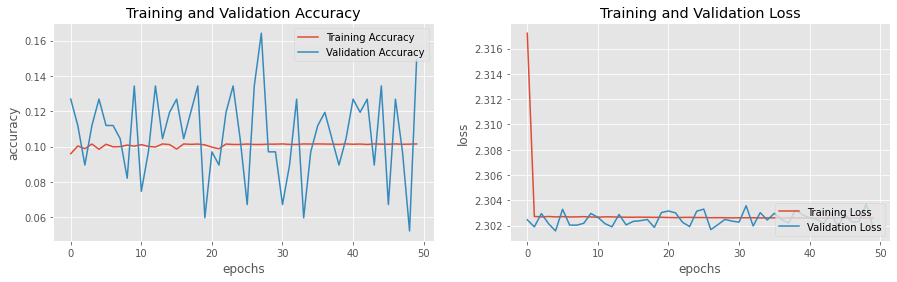

In [14]:
import matplotlib.pyplot as plt

acc = model_VGG19.history.history['accuracy']
val_acc = model_VGG19.history.history['val_accuracy']

loss= model_VGG19.history.history['loss']
val_loss= model_VGG19.history.history['val_loss']


plt.style.use("ggplot")
#  "Accuracy"
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
#  "Loss"
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.show()

###**จุด Checkpoint**

In [15]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

'training_VGG19/cp-0050.ckpt'

In [18]:
# Load the previously saved weights
model_VGG19.load_weights(latest)

# Re-evaluate the model
loss, acc = model_VGG19.evaluate(valid_generator, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

4303/4303 - 33s - loss: 2.3026 - accuracy: 0.1013
Restored model, accuracy: 10.13%


###**Save model อีกเเบบเพื่อนำไปเเปลงเป็น TensorflwLite**

In [16]:
# Save the entire model as a SavedModel.
model_VGG19.save('saved_model/my_model') 

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [ ]:
model= tf.keras.models.load_model('saved_model/my_model')
tflite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tflite_converter.convert()
open("tf_lite_model(200epochsvgg19).tflite", "wb").write(tflite_model) 

###**ขั้นตอนของ Prediction เเบบบ Confusion Matrix**

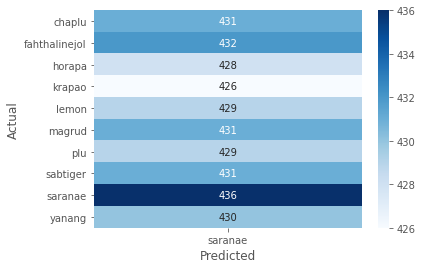

test accuracy : 10.016267720195213


In [17]:
import seaborn as sn
import pandas as pd

model = tf.keras.models.load_model('saved_model/my_model')
filenames = valid_generator.filenames
nb_samples = len(valid_generator)
y_prob=[]
y_act=[]
valid_generator.reset()
for _ in range(nb_samples):
    x_test, y_test = valid_generator.next()
    y_prob.append(model.predict(x_test))
    y_act.append(y_test)


predicted_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_prob]
actual_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_act]

out_df = pd.DataFrame(np.vstack([predicted_class,actual_class]).T,columns=['predicted_class', 'actual_class'])
confusion_matrix = pd.crosstab(out_df['actual_class'],out_df['predicted_class'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, cmap='Blues', annot= True, fmt='d')
plt.show()
print('test accuracy : {}'.format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100)))